In [ ]:
!pip install mtcnn
!pip install keras_applications
!pip install keras_vggface

In [ ]:
import mtcnn
import keras_vggface
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import zipfile
import tensorflow as tf
from tensorflow.python.keras.api._v1 import keras
from tensorflow.python.keras.api._v1.keras import layers
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import time

In [ ]:
detector = MTCNN()

In [ ]:
# extract all faces from a given photograph
def extract_faces(pixels, detector, required_size=(150, 150)):
    results = detector.detect_faces(pixels)
    faces_array = []
    pos = []
    if(len(results) > 0):
        for obj in results:
            x1, y1, width, height = obj['box']
            pos.append(obj['box'])
            x2, y2 = x1 + width, y1 + height
            face = pixels[y1:y2, x1:x2]
            if(len(face) > 0 and len(face[0]) > 0):
                image = Image.fromarray(face)
                image = image.resize(required_size)
                face_array = np.asarray(image)
            faces_array.append(face_array)
    return faces_array, pos

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
mask_images = load_images_from_folder('/content/drive/Shareddrives/484 fall 2020/random_stuff/small_sample')

In [ ]:
#read in images and collect all faces
output = []
output_pos = []
for image in mask_images:
    pixels, pos = extract_faces(image, detector)
    output_pos += pos
    for obj in pixels:
        output.append(obj)

In [ ]:
print(output_pos)

[[321, 46, 31, 35], [433, 238, 90, 114], [372, 46, 19, 23], [260, 140, 34, 48], [537, 110, 32, 40], [540, 65, 28, 32], [160, 147, 77, 100], [461, 61, 14, 18], [314, 79, 27, 33], [213, 70, 34, 37], [60, 152, 90, 106], [158, 33, 25, 32], [235, 33, 15, 18], [185, 21, 14, 18], [295, 53, 22, 26], [82, 43, 17, 22], [348, 75, 21, 25], [271, 5, 13, 15], [417, 108, 64, 84], [574, 64, 14, 18], [594, 44, 26, 34], [255, 48, 22, 25], [86, 15, 13, 15], [102, 42, 25, 32], [350, 117, 24, 30], [277, 42, 14, 17], [478, 183, 61, 70], [379, 276, 56, 70], [105, 145, 111, 123], [615, 154, 87, 97], [818, 182, 112, 128], [728, 145, 75, 96]]


In [ ]:
#write faces to file
root = '/content/drive/Shareddrives/484 fall 2020/random_stuff/output'
counter = 0
for image in output:
    name = 'img' + str(counter) + '.jpg'
    temp = root + name
    if(len(image) > 0):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(temp, np.array(image))
        counter = counter + 1

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/484 fall 2020/trained/model-1606455604')

In [ ]:
def extract_face_array(output):
  faces_found = None
  for obj in output:
      image = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)
      image = tf.reshape(image, [-1, 150, 150, 1])
      if faces_found is None:
          faces_found = image
      else:
          faces_found = np.append(faces_found, image, axis=0)
  return faces_found

(32, 150, 150, 1)


In [ ]:
result = model.predict(faces_found)

In [ ]:
def output_faces(image, detector):
    output = []
    output_pos = []
    pixels, pos = extract_faces(image, detector)
    output_pos += pos
    for obj in pixels:
        output.append(obj)
    return output, output_pos

In [ ]:
# drawing on each multi face images
classes = {0: 'faces', 1: 'inc_masked', 2: 'masked'}
pred_imgs = []
for image in mask_images:
    output, output_pos = output_faces(image, detector)
    crop_faces = extract_face_array(output)
    result = model.predict(crop_faces)
    pred_img = image
    for pred, pos in zip(result, output_pos):
        x, y, w, h = pos
        pred_img = cv2.rectangle(pred_img, (x, y), (x + w, y + h), (0,255,0), 1)
        cv2.putText(pred_img, classes[np.argmax(pred)], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 2)
    pred_imgs.append(pred_img)


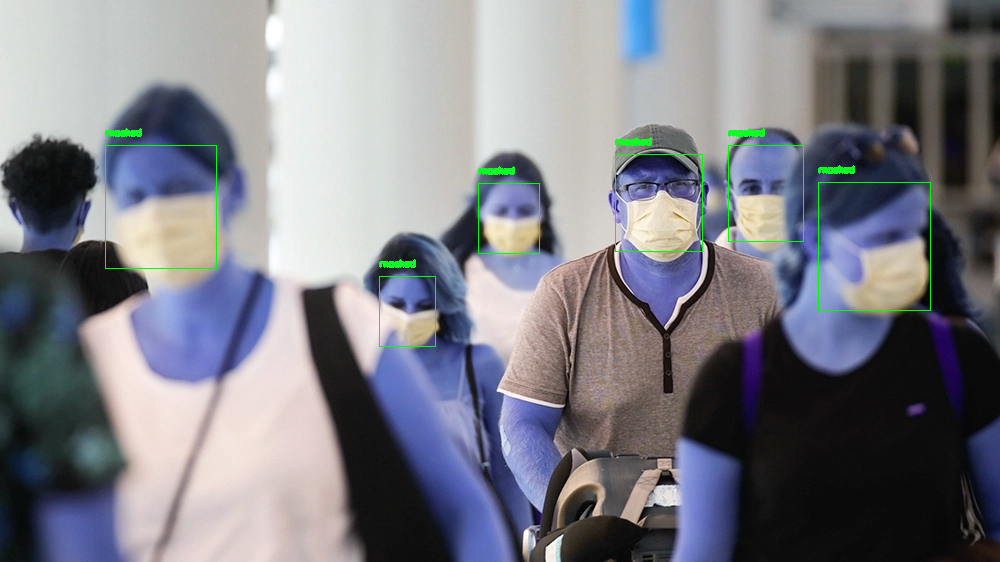

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(pred_imgs[1])